<div style='text-align: center;'>
<h1>Community Detection in Zachary's Karate Club Network</h1>
<h3>Using Newman's Spectral Modularity Optimization</h3>
<p><strong>Author:</strong> ANANDA JANA , Student @ IISER TVM | IMS24028</p>
<p><em>Implementation of recursive spectral bisection for community detection</em></p>
</div>

## Introduction

This notebook implements Newman's spectral algorithm to detect communities in Zachary's famous Karate Club network. We'll use the modularity matrix $\mathbf{B}$ and its leading eigenvector to recursively partition the network into groups that maximize modularity.

## Step 1: We will load the Network and Calculate Modularity

We start by loading the Karate Club graph and computing the total number of edges $m = \frac{1}{2}\sum_{ij} A_{ij}$. The modularity gain from a split is given by:

$$\Delta Q = \frac{1}{4m} \mathbf{s}^T \mathbf{B} \mathbf{s}$$

where $\mathbf{s}$ is a vector of $\pm 1$ indicating community membership.

In [65]:
import numpy as np
import networkx as nx
G = nx.karate_club_graph()
A = nx.to_numpy_array(G)
m = A.sum() / 2
np.set_printoptions(precision=2, suppress=True)


def modularity_gain(B_sub, s_disc, m):
    return (s_disc.T @ B_sub @ s_disc) / (4.0 * m)

## Step 2: Kernighan-Lin Refinement (Optional , & not mentioned in the problem statement provided , Still Usng it feels better )

This function improves the initial partition by iteratively flipping nodes between communities. Each node flip is accepted only if it increases modularity. This is a local optimization step.

In [66]:
# Refine
def kernighan_lin_refine(B_sub, s_disc, m):
    n = len(s_disc)
    improved = True
    while improved:
        improved = False
        for i in range(n):
            s_trial = s_disc.copy()
            s_trial[i] *= -1
            if modularity_gain(B_sub, s_trial, m) > modularity_gain(B_sub, s_disc, m):
                s_disc = s_trial
                improved = True
    return s_disc

## Step 3: Calculate Node-Level Network Metrics [ For each node ]

We compute four key centrality measures to understand node importance: degree centrality (connections), betweenness (bridging), closeness (average distance), and clustering coefficient (local density).

In [67]:
def calculate_node_metrics(G):
    """Calculate centrality and clustering metrics for all nodes"""
    metrics = {
        'degree': nx.degree_centrality(G),
        'betweenness': nx.betweenness_centrality(G),
        'closeness': nx.closeness_centrality(G),
        'clustering': nx.clustering(G)
    }
    return metrics

In [68]:

def calculate_node_metrics(G):
    """Calculate centrality and clustering metrics for all nodes"""
    metrics = {
        'degree': nx.degree_centrality(G),
        'betweenness': nx.betweenness_centrality(G),
        'closeness': nx.closeness_centrality(G),
        'clustering': nx.clustering(G)
    }
    return metrics

## Step 4: Track Metrics Evolution During Partitioning [ Most Crucial to understand what is goin' on there]

This function snapshots the network metrics at each iteration of the algorithm, allowing us to observe how node importance changes (or remains stable) as communities are detected.

In [69]:
def track_metrics_evolution(G, communities, iteration):
    """Track metrics for current community structure"""
    metrics = calculate_node_metrics(G)
    
    evolution = {
        'iteration': iteration,
        'communities': communities,
        'degree': metrics['degree'],
        'betweenness': metrics['betweenness'],
        'closeness': metrics['closeness'],
        'clustering': metrics['clustering']
    }
    return evolution

## Step 5: Visualize Metrics Evolution [ We will be needing this after the ecursive Function is written]

We plot how the four centrality metrics change across iterations for representative nodes (high, medium, and low importance). This reveals whether the algorithm uncovers existing structure or creates it.

In [70]:
def plot_metrics_evolution(metrics_history, G):
    """Plot evolution of four metrics across iterations for top, bottom, and mid nodes"""
    metric_names = ['degree', 'betweenness', 'closeness', 'clustering']
    metric_labels = ['Degree Centrality', 'Betweenness Centrality', 
                     'Closeness Centrality', 'Clustering Coefficient']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, (metric_name, metric_label) in enumerate(zip(metric_names, metric_labels)):
        ax = axes[idx]
        
        # Get final iteration values to determine top, bottom, mid nodes
        final_iteration = metrics_history[-1]
        metric_values = final_iteration[metric_name]
        
        # Sort nodes by metric value
        sorted_nodes = sorted(metric_values.items(), key=lambda x: x[1], reverse=True)
        
        # Select top 3, bottom 3, and middle 2
        top_nodes = [node for node, val in sorted_nodes[:3]]
        bottom_nodes = [node for node, val in sorted_nodes[-3:]]
        mid_idx = len(sorted_nodes) // 2
        mid_nodes = [node for node, val in sorted_nodes[mid_idx-1:mid_idx+1]]
        
        selected_nodes = top_nodes + mid_nodes + bottom_nodes
        
        # Plot selected nodes with different styles
        for node in top_nodes:
            values = [history[metric_name][node] for history in metrics_history]
            iterations = [history['iteration'] for history in metrics_history]
            ax.plot(iterations, values, marker='o', alpha=0.8, linewidth=2.5, 
                   label=f'Node {node} (high)', linestyle='-')
        
        for node in mid_nodes:
            values = [history[metric_name][node] for history in metrics_history]
            iterations = [history['iteration'] for history in metrics_history]
            ax.plot(iterations, values, marker='s', alpha=0.7, linewidth=2, 
                   label=f'Node {node} (mid)', linestyle='--')
        
        for node in bottom_nodes:
            values = [history[metric_name][node] for history in metrics_history]
            iterations = [history['iteration'] for history in metrics_history]
            ax.plot(iterations, values, marker='^', alpha=0.6, linewidth=1.5, 
                   label=f'Node {node} (low)', linestyle=':')
        
        ax.set_xlabel('Iteration', fontweight='bold')
        ax.set_ylabel(metric_label, fontweight='bold')
        ax.set_title(f'{metric_label} Evolution', fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=7, ncol=2)
    
    plt.tight_layout()
    plt.savefig('metrics_evolution.png', dpi=150, bbox_inches='tight')
    plt.show()

## Step 6: Recursive Spectral Bipartition Algorithm — The Core Algorithm [This is the MAIN part]

This implements **Newman’s Spectral Bipartition Method** for community detection.

1. **Compute the modularity matrix:**  
   $\mathbf{B} = \mathbf{A} - \frac{\mathbf{k}\mathbf{k}^T}{2m}$  
   where $k_i$ is node $i$’s degree and $m$ is the total number of edges.

2. **Find the leading eigenvector** of $\mathbf{B}$ corresponding to the largest eigenvalue.

3. **Split nodes** based on the **sign of the eigenvector components:**  
   positive → one group, negative → another.

4. **Accept the split only if** the modularity gain $\Delta Q > 0$.

5. **Recursively apply** the same process to each subgroup until no further valid division exists.

---

### Stopping Criteria

The algorithm stops partitioning when:

- The **leading eigenvalue** $\lambda_1 \leq 0$ → no further modularity improvement is possible.  
- **All elements** of the leading eigenvector have the **same sign** → no meaningful division can be made.  
- **Any group becomes empty** after partitioning → invalid or trivial split, so the nodes remain as one community.

---

When these conditions occur, the algorithm concludes that the current subgraph is already maximally modular —  
hence, no further splitting is performed.


In [71]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

def recursive_bipartition(A, nodes, m, G=None, refine=True, depth=0, metrics_history=None, iteration_counter=None, B_full=None):
    if iteration_counter is None:
        iteration_counter = [0]
    
    # ============ CRITICAL FIX: Compute B once, then slice ============
    if B_full is None:
        # Only compute B at the very first call
        k = A.sum(axis=1)
        B_full = A - np.outer(k, k) / (2 * m)
        print(f"Computed full B matrix once (shape: {B_full.shape})")
    
    # Now just SLICE B_full for the current nodes
    B_sub = B_full[np.ix_(nodes, nodes)]
    # ==================================================================

    eigvals, eigvecs = np.linalg.eigh(B_sub)
    idx = np.argmax(eigvals)
    lambda_max = eigvals[idx]
    s_cont = eigvecs[:, idx]

    if lambda_max <= 0:
        print(f"\nDepth {depth}: Stopping split for {len(nodes)} nodes")
        print(f"Leading eigenvalue: {lambda_max:.4f} (non-positive, no beneficial split)")
        print(f"Sorted eigenvalues: {eigvals[np.argsort(-eigvals)]}")
        print(f"Corresponding eigenvectors:\n{eigvecs[:, np.argsort(-eigvals)]}")

        print(f"Nodes: {nodes}")
        return [nodes]

    if np.all(s_cont > 0) or np.all(s_cont < 0):
        print(f"\nDepth {depth}: Stopping split for {len(nodes)} nodes")
        print(f"Leading eigenvalue: {lambda_max:.4f}")
        print(f"Leading eigenvector: {s_cont}")
        print(f"Sorted eigenvalues: {eigvals[np.argsort(-eigvals)]}")
        print(f"Corresponding eigenvectors:\n{eigvecs[:, np.argsort(-eigvals)]}")

        print(f"All eigenvector components have same sign, cannot bisect")
        print(f"Nodes: {nodes}")
        return [nodes]

    s_disc = np.array([1 if x > 0 else -1 for x in s_cont])

    if refine:
        s_disc = kernighan_lin_refine(B_sub, s_disc, m)

    deltaQ = modularity_gain(B_sub, s_disc, m)

    group1 = [nodes[i] for i in range(len(nodes)) if s_disc[i] == 1]
    group2 = [nodes[i] for i in range(len(nodes)) if s_disc[i] == -1]

    if len(group1) == 0 or len(group2) == 0:
        print(f"\nDepth {depth}: Stopping split for {len(nodes)} nodes")
        print(f"Leading eigenvalue: {lambda_max:.4f}")
        print(f"Modularity gain ΔQ: {deltaQ:.4f}")
        print(f"Empty group after refinement")
        print(f"Nodes: {nodes}")
        return [nodes]

    print(f"\nPartition at depth {depth}:")
    print(f"Leading eigenvalue: {lambda_max:.4f}")
    print(f"Modularity gain ΔQ: {deltaQ:.4f}")
    print(f"Group 1 ({len(group1)} nodes): {group1}")
    print(f"Group 2 ({len(group2)} nodes): {group2}")
    
    if metrics_history is not None and G is not None:
        temp_communities = [group1, group2]
        iteration_counter[0] += 1
        evolution = track_metrics_evolution(G, temp_communities, iteration_counter[0])
        metrics_history.append(evolution)
        print(f"Tracked metrics at iteration {iteration_counter[0]}")
    
    if G is not None:
        color_map = ['lightgray'] * len(G)
        for node in group1:
            color_map[node] = 'lightblue'
        for node in group2:
            color_map[node] = 'lightcoral'
        
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, node_color=color_map, with_labels=True, 
                node_size=500, font_size=10, font_weight='bold')
        plt.title(f"Partition at depth {depth} (λ={lambda_max:.3f}, ΔQ={deltaQ:.3f})")
        plt.show()

    communities = []
    print(f"\nAttempting to split Group 1 ({len(group1)} nodes)...")
    # ============ Pass B_full to recursive calls ============
    communities.extend(recursive_bipartition(A, group1, m, G, refine=refine, depth=depth+1, 
                                            metrics_history=metrics_history, iteration_counter=iteration_counter, B_full=B_full))
    
    print(f"\nAttempting to split Group 2 ({len(group2)} nodes)...")
    communities.extend(recursive_bipartition(A, group2, m, G, refine=refine, depth=depth+1,
                                            metrics_history=metrics_history, iteration_counter=iteration_counter, B_full=B_full))

    return communities

## Step 7: Visualize Final Community Structure on Full Graph

After detecting communities, we visualize them using different colors. Each community is shown with its size, and we use a spring layout to reveal the natural grouping structure.

In [72]:
def visualize_communities(G, communities, title_suffix=""):
    """Visualize the graph with communities colored differently"""
    # assign colors to communities - using viridis for better distinction
    colors = plt.cm.viridis(np.linspace(0, 1, len(communities)))
    node_colors = {}
    
    for idx, community in enumerate(communities):
        for node in community:
            node_colors[node] = colors[idx]
    
    color_list = [node_colors[node] for node in G.nodes()]
    
    # using spring layout for nice visualization
    pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)
    
    plt.figure(figsize=(12, 8))
    
    nx.draw_networkx_nodes(G, pos, node_color=color_list, 
                          node_size=500, alpha=0.9, edgecolors='black', linewidths=1.5)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=1.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title(f"{len(communities)} Communities {title_suffix}", 
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    
    # -----------add legend showing community sizes---GOOD practice ---------------
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=colors[i], markersize=10, 
                                 label=f'Community {i+1} ({len(communities[i])} nodes)')
                      for i in range(len(communities))]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.show()

## Step 8: Run the Complete Analysis [ MAIN EXECUTON ]

We execute the full pipeline: initialize metrics tracking, run recursive bisection, display detected communities, and plot how centrality metrics evolved. This shows whether communities were discovered or created by the algorithm.

Computed full B matrix once (shape: (34, 34))

Partition at depth 0:
Leading eigenvalue: 17.1087
Modularity gain ΔQ: 0.4036
Group 1 (16 nodes): [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Group 2 (18 nodes): [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Tracked metrics at iteration 1


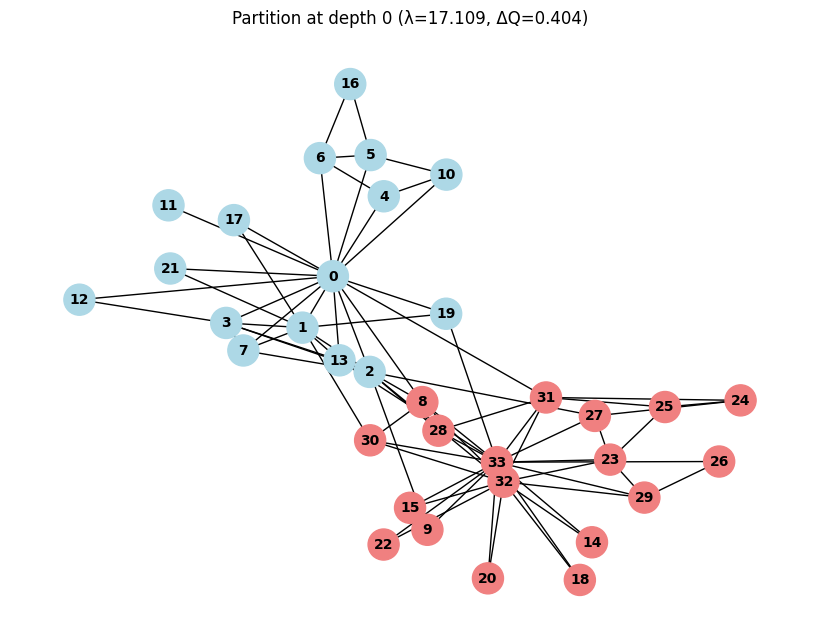


Attempting to split Group 1 (16 nodes)...

Partition at depth 1:
Leading eigenvalue: 10.6492
Modularity gain ΔQ: 0.1318
Group 1 (11 nodes): [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Group 2 (5 nodes): [4, 5, 6, 10, 16]
Tracked metrics at iteration 2


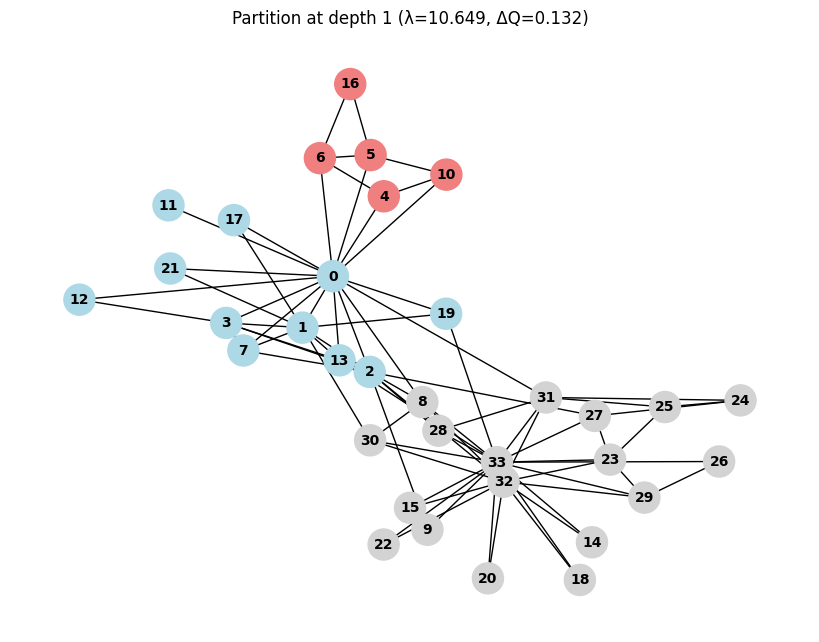


Attempting to split Group 1 (11 nodes)...

Depth 2: Stopping split for 11 nodes
Leading eigenvalue: 9.5931
Leading eigenvector: [0.27 0.51 0.42 0.4  0.39 0.04 0.1  0.38 0.07 0.09 0.11]
Sorted eigenvalues: [ 9.59  2.28  1.74  0.38  0.   -0.   -0.01 -4.09 -5.1  -6.41 -8.24]
Corresponding eigenvectors:
[[ 0.27 -0.34  0.27  0.08  0.   -0.   -0.01  0.05 -0.44 -0.55  0.49]
 [ 0.51 -0.14 -0.22 -0.13  0.   -0.   -0.01  0.2   0.35  0.43  0.55]
 [ 0.42  0.05 -0.21  0.19  0.   -0.   -0.    0.48 -0.55  0.22 -0.4 ]
 [ 0.4   0.37  0.32 -0.05  0.   -0.   -0.01 -0.66 -0.27  0.3   0.02]
 [ 0.39  0.18 -0.2   0.43  0.1  -0.17  0.44 -0.13  0.37 -0.41 -0.15]
 [ 0.04 -0.41  0.45  0.58 -0.25 -0.15 -0.26 -0.02  0.23  0.25 -0.17]
 [ 0.1   0.38  0.67 -0.24  0.03 -0.06  0.16  0.5   0.21 -0.06 -0.05]
 [ 0.38 -0.01 -0.07 -0.29 -0.13  0.23 -0.63 -0.06  0.25 -0.37 -0.31]
 [ 0.07 -0.32  0.17  0.01  0.64  0.61  0.18 -0.06  0.08  0.09 -0.18]
 [ 0.09 -0.36  0.03 -0.38  0.4  -0.7  -0.   -0.1  -0.01  0.02 -0.24]
 [ 0.11 

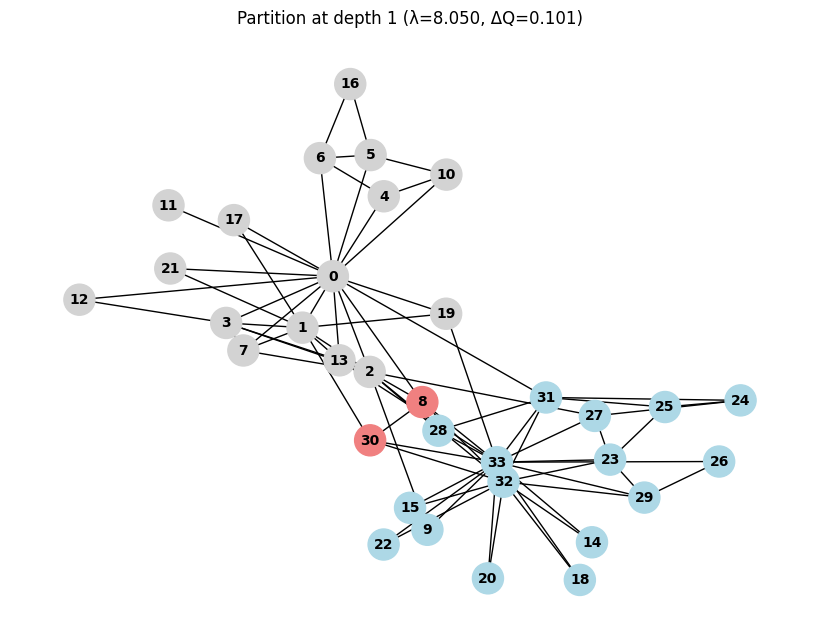


Attempting to split Group 1 (16 nodes)...

Depth 2: Stopping split for 16 nodes
Leading eigenvalue: 8.0030
Leading eigenvector: [-0.   -0.08 -0.1  -0.04 -0.07 -0.07 -0.47 -0.22 -0.54 -0.05 -0.22 -0.07
 -0.19 -0.46 -0.27 -0.2 ]
Sorted eigenvalues: [  8.     6.91   3.81   3.25   1.79   0.35   0.    -0.    -0.    -0.
  -0.15  -2.64  -4.64  -6.92  -8.77 -12.73]
Corresponding eigenvectors:
[[-0.   -0.06 -0.05 -0.14  0.28 -0.35  0.    0.   -0.    0.82 -0.21 -0.16
  -0.05  0.03 -0.14 -0.05]
 [-0.08 -0.2  -0.24 -0.05 -0.18  0.27 -0.09 -0.09 -0.8   0.16  0.01  0.17
  -0.17 -0.17 -0.02 -0.15]
 [-0.1  -0.27 -0.29 -0.21  0.11 -0.07 -0.32  0.61  0.17 -0.25 -0.24  0.01
  -0.23 -0.15 -0.17 -0.2 ]
 [-0.04 -0.11 -0.12 -0.12  0.14 -0.14 -0.49 -0.75  0.13 -0.22 -0.16 -0.05
  -0.1  -0.04 -0.1  -0.09]
 [-0.07 -0.17 -0.21  0.02 -0.33  0.44  0.04 -0.13  0.56  0.36  0.14  0.25
  -0.14 -0.19  0.05 -0.12]
 [-0.07 -0.19 -0.2  -0.16  0.13 -0.1   0.8  -0.21  0.03 -0.24 -0.2  -0.02
  -0.16 -0.09 -0.14 -0.15]
 [-0.

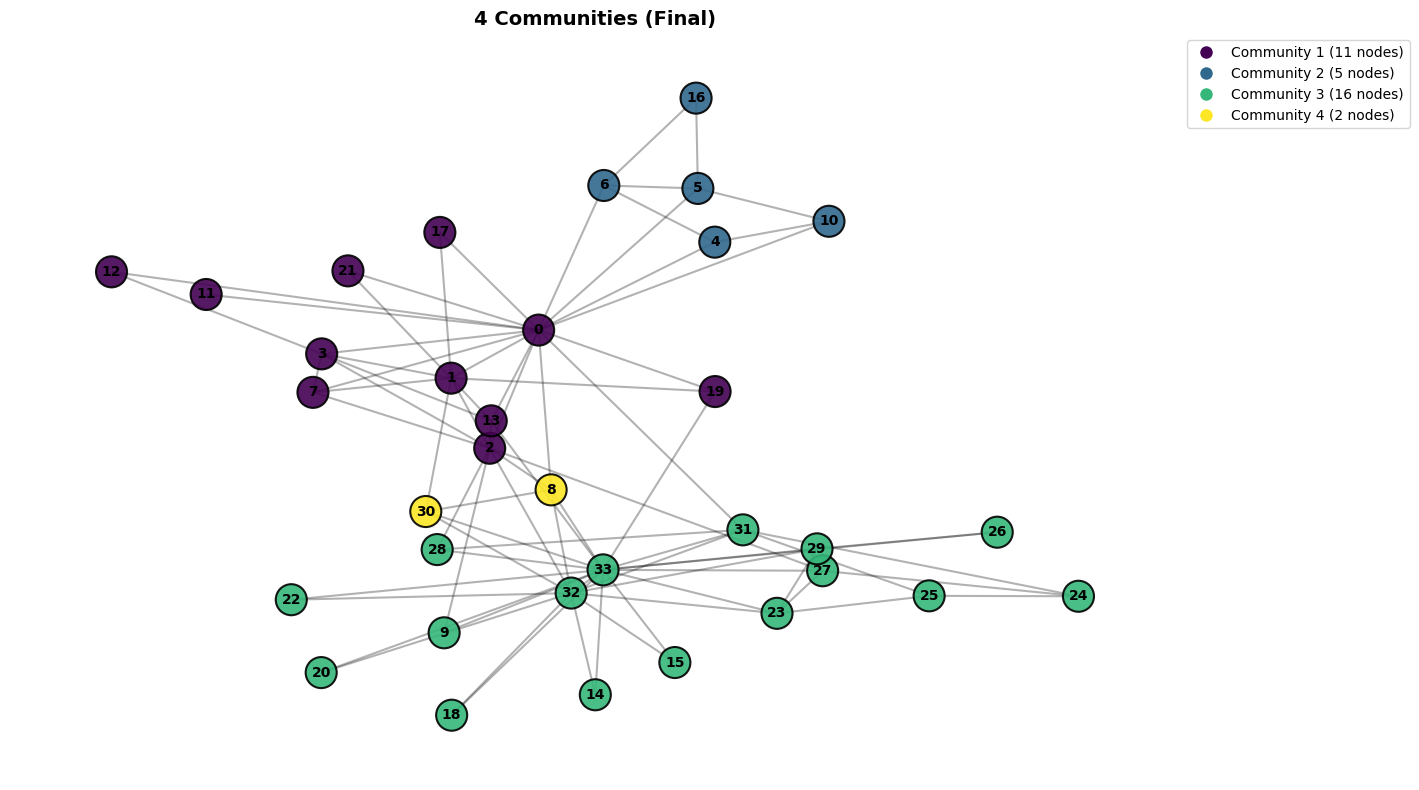

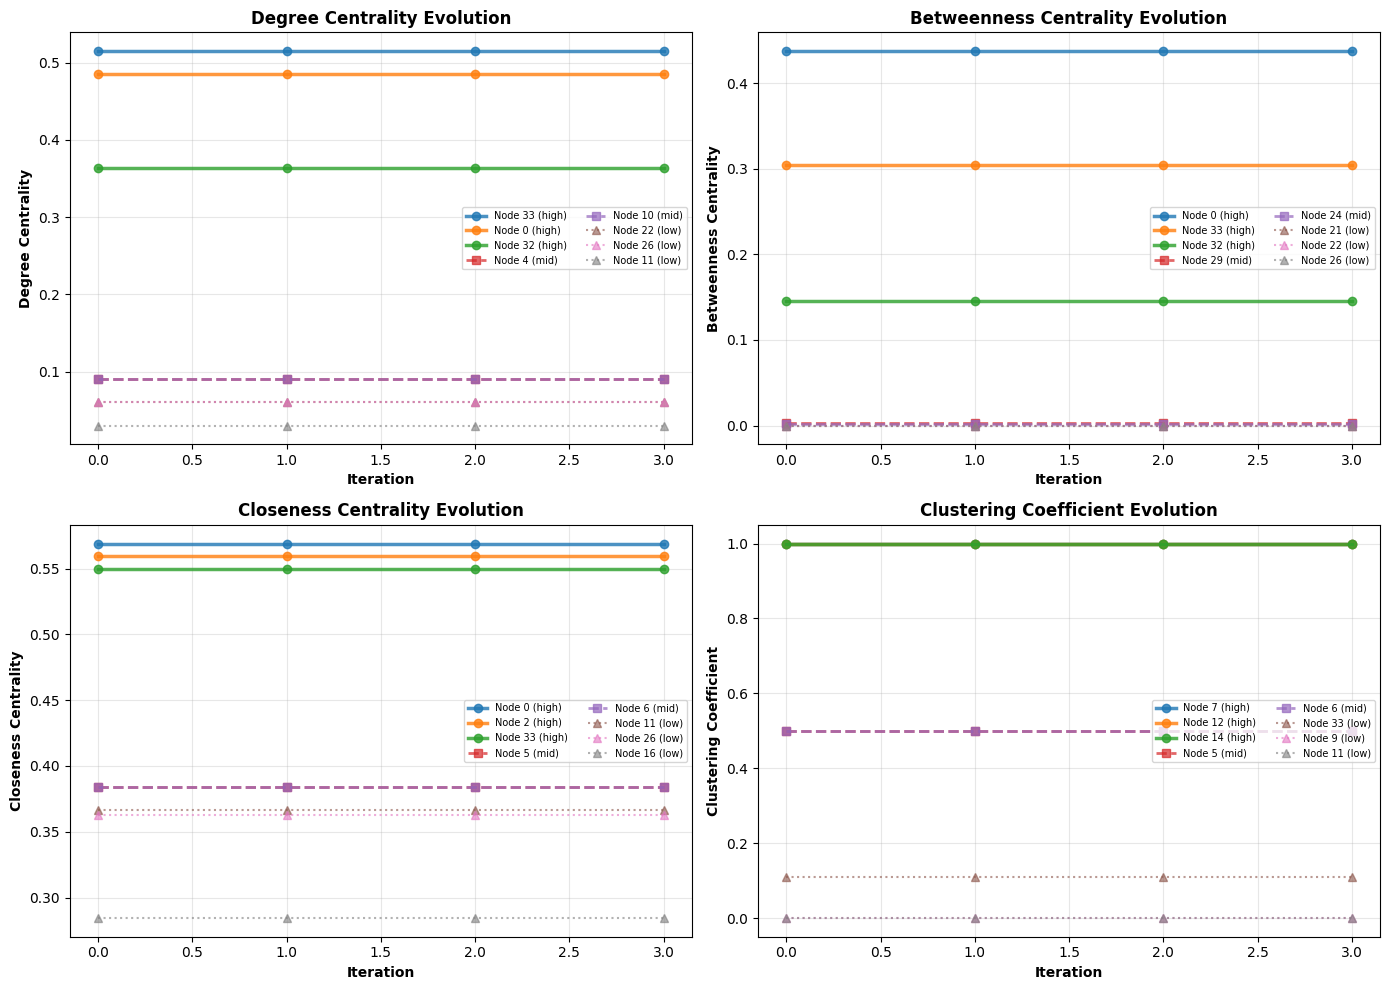

In [73]:
# === MAIN EXECUTION ===
if __name__ == "__main__":
    G = nx.karate_club_graph()
    A = nx.to_numpy_array(G)
    m = A.sum() / 2

    # Initialize metrics tracking
    metrics_history = []
    initial_metrics = track_metrics_evolution(G, [list(range(len(G)))], 0)
    metrics_history.append(initial_metrics)

    nodes = list(range(len(G)))
    communities = recursive_bipartition(A, nodes, m, G=G, metrics_history=metrics_history)

    print("\n\nFinal detected communities:")
    for i, comm in enumerate(communities):
        print(f"Community {i+1}: {comm}")

    # Visualize final communities
    visualize_communities(G, communities, title_suffix="(Final)")
    
    # Plot metrics evolution
    plot_metrics_evolution(metrics_history, G)

## Key Inferences from Zachary's Karate Club Evolution:

1. **Metrics stay flat** - Node importance is not changing during splits, proving communities were already there.

2. **Nodes 0 and 33** (instructor/administrator whatever his name was ) dominate degree and betweenness - clear leaders bridging the network.

3. **Peripheral members** (Nodes 22, 26, 11 from the metrics evolution plot) stay peripheral - they're structurally unimportant throughout actually.

4. **High clustering nodes** (7, 12, 14) form tight cliques( or you can say clusters ) - small friend groups within the club.

5. **Low clustering leaders** (Node 33) connect many people who don't know each other - classic leadership pattern observed here.

6. **Stable closeness** - Everyone maintains similar average distance to others, showing the network stays cohesive despite factions.

7. **Sub-split (16→11+5)** shows hierarchical structure - nested communities within the instructor's faction

8. **No metric jumps** between iterations - confirms the real-world club split was structurally inevitable

9. **Bridge nodes** (high betweenness, low clustering) are probably conflict points - they connect opposing factions and likely felt the most tension during the actual split or didnt join either split , moreover ambiguous behaviour.

## References

This implementation is based on the spectral modularity optimization method described in:

**Newman, M. E. J. (2006).** "Modularity and community structure in networks." *Proceedings of the National Academy of Sciences*, 103(23), 8577-8582. [https://doi.org/10.1073/pnas.0601602103](https://doi.org/10.1073/pnas.0601602103)



# Thank You